In [1]:
! pip install clickhouse_driver
! pip install mysql.connector
! pip install seaborn
! pip install plotly
! pip install sqlalchemy
! pip install sqlalchemy-clickhouse

Processing c:\users\marus\appdata\local\pip\cache\wheels\42\2f\c3\692fc7fc1f0d8c06b9175d94f0fc30f4f92348f5df5af1b8b7\mysql_connector-2.2.9-cp37-cp37m-win_amd64.whl


In [2]:
from clickhouse_driver import Client
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import plotly.express as px

In [42]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [4]:
NY = pd.read_csv('NY_Listings.csv', sep=',', encoding='latin1')

C:\Users\marus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (7,19,24) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
NY.rename(columns={'Listing ID': 'Listing_ID', 'Host Name': 'Host_Name', 'Host total listings count': 'Host_total_listings_count', 'Host ID': 'Host_ID', 'Host Response Rate': 'Host_Response_Rate', 'Host Is Superhost': 'Host_Is_Superhost', 'Host total listings_count': 'Host_total_listings_count', 'Neighbourhood cleansed': 'Neighbourhood_cleansed', 'Property type': 'Property_type', 'Room type': 'Room_type', 'Minimum nights': 'Minimum_nights', 'Maximum nights': 'Maximum_nights', 'Availability 365': 'Availability_365', 'Calendar last scraped': 'Calendar_last_scraped', 'Number of reviews': 'Number_of_reviews', 'Last Review Date': 'Last_Review_Date', 'Review Scores Rating': 'Review_Scores_Rating', 'Review Scores Accuracy': 'Review_Scores_Accuracy', 'Review Scores Cleanliness': 'Review_Scores_Cleanliness', 'Review Scores Checkin': 'Review_Scores_Checkin', 'Review Scores Communication': 'Review_Scores_Communication', 'Review Scores Location': 'Review_Scores_Location', 'Review Scores Value': 'Review_Scores_Value', 'Reviews per month': 'Reviews_per_month', }, inplace=True)

Посмотрим, как сооьносятся между собой разные типы рейтингов. 
Оказывается, что разные типы рейтингов хорошо коррелируют друг с другом, то есть коэффициент корреляции равен 0.98-0.99, то есть есть линейная зависимость: если в доме, например, чисто, то и остальные параметры будут достаточно высокими.
То есть пользователи с хорошим одним параметром, скорее всего имеют и по остальным параметрам достаточно высокий рейтинг

С общим рейтингом это почему-то слабо коррелируется

Нет связи между ценой и рейтингом, то есть цена не зависит линейно от отзывов.

In [11]:
cols = NY[['Price','Host_total_listings_count','Review_Scores_Rating' ,'Review_Scores_Accuracy','Review_Scores_Cleanliness','Review_Scores_Communication','Review_Scores_Location','Review_Scores_Value']]
hide_toggle()

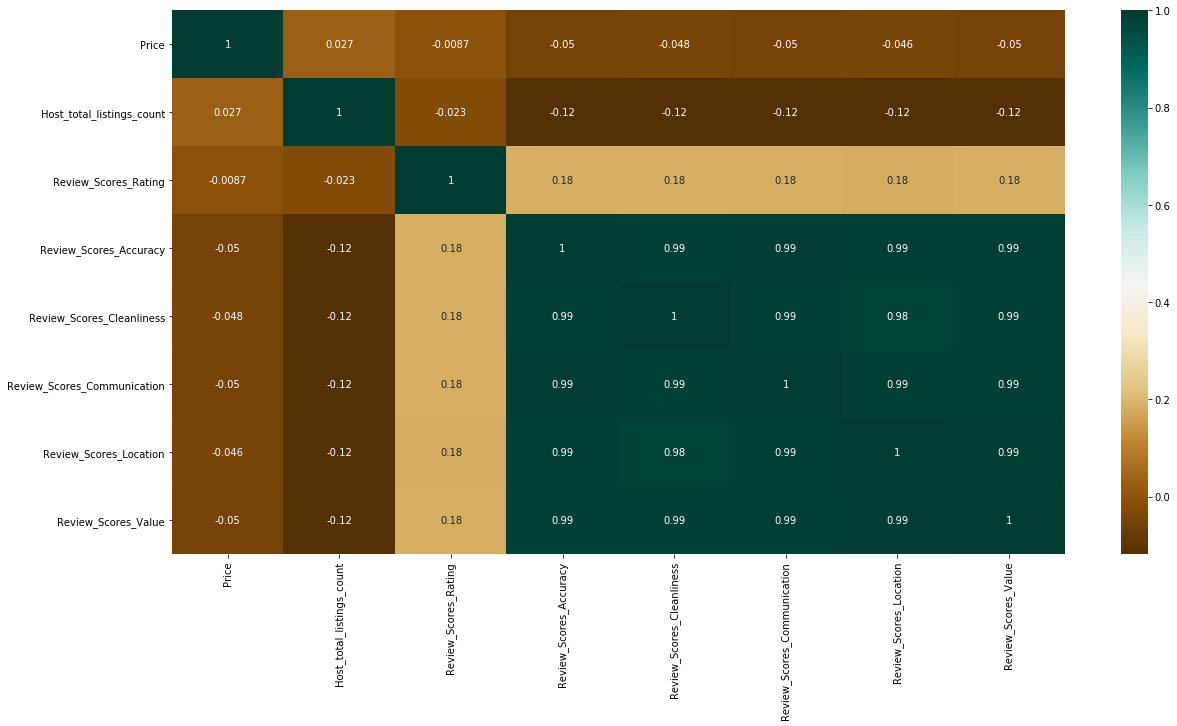

In [9]:
plt.figure(figsize=(20,10))
c= cols.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
hide_toggle()


В дополнение к письменным отзывам, гости могут предоставить общий рейтинг и набор рейтингов звезд. Гости могут дать оценки на:

Общий опыт. Каким был ваш общий опыт?

Чистота. Вы чувствовали, что ваше пространство было чистым и опрятным?

Точность. Насколько точно ваша страница листинга представляла ваше пространство?

Цена\качество. Чувствовали ли вы, что ваше объявление обеспечило хорошее соотношение цены?

Общение. Насколько хорошо вы общались с хозяином до и во время их пребывания?

Прибытие. Насколько гладко прошла их регистрация?

Расположение. Как вы относились к окрестностям?

Ниже вы можете увидеть распределение баллов по всем этим категориям. (графики зависимости количества отзывов от средней оценки)


Что сразу бросилось в глаза, так это то, что оценки кажутся действительно высокими 
по всем направлениям! Быстрый поиск в интернете показал мне, что это похоже на Airbnb. 
95% хостов Airbnb оцениваются от 4,5 до 5 звезд.

Посмотрев распределение баллов, я лично считаю, что любая оценка 8 или ниже не является хорошей. 
Если бы я хотел использовать какой-либо из этих показателей в поиске жилья, я считаю, что «Цена\качество»
кажется наиболее полезным. Прежде всего, я всегда хочу получить хорошее соотношение цены и качества. 

То есть можно оставить всех людей, у которых оценка по всем критериям 9 или 10  и по критерию «Цена\качество»  10.

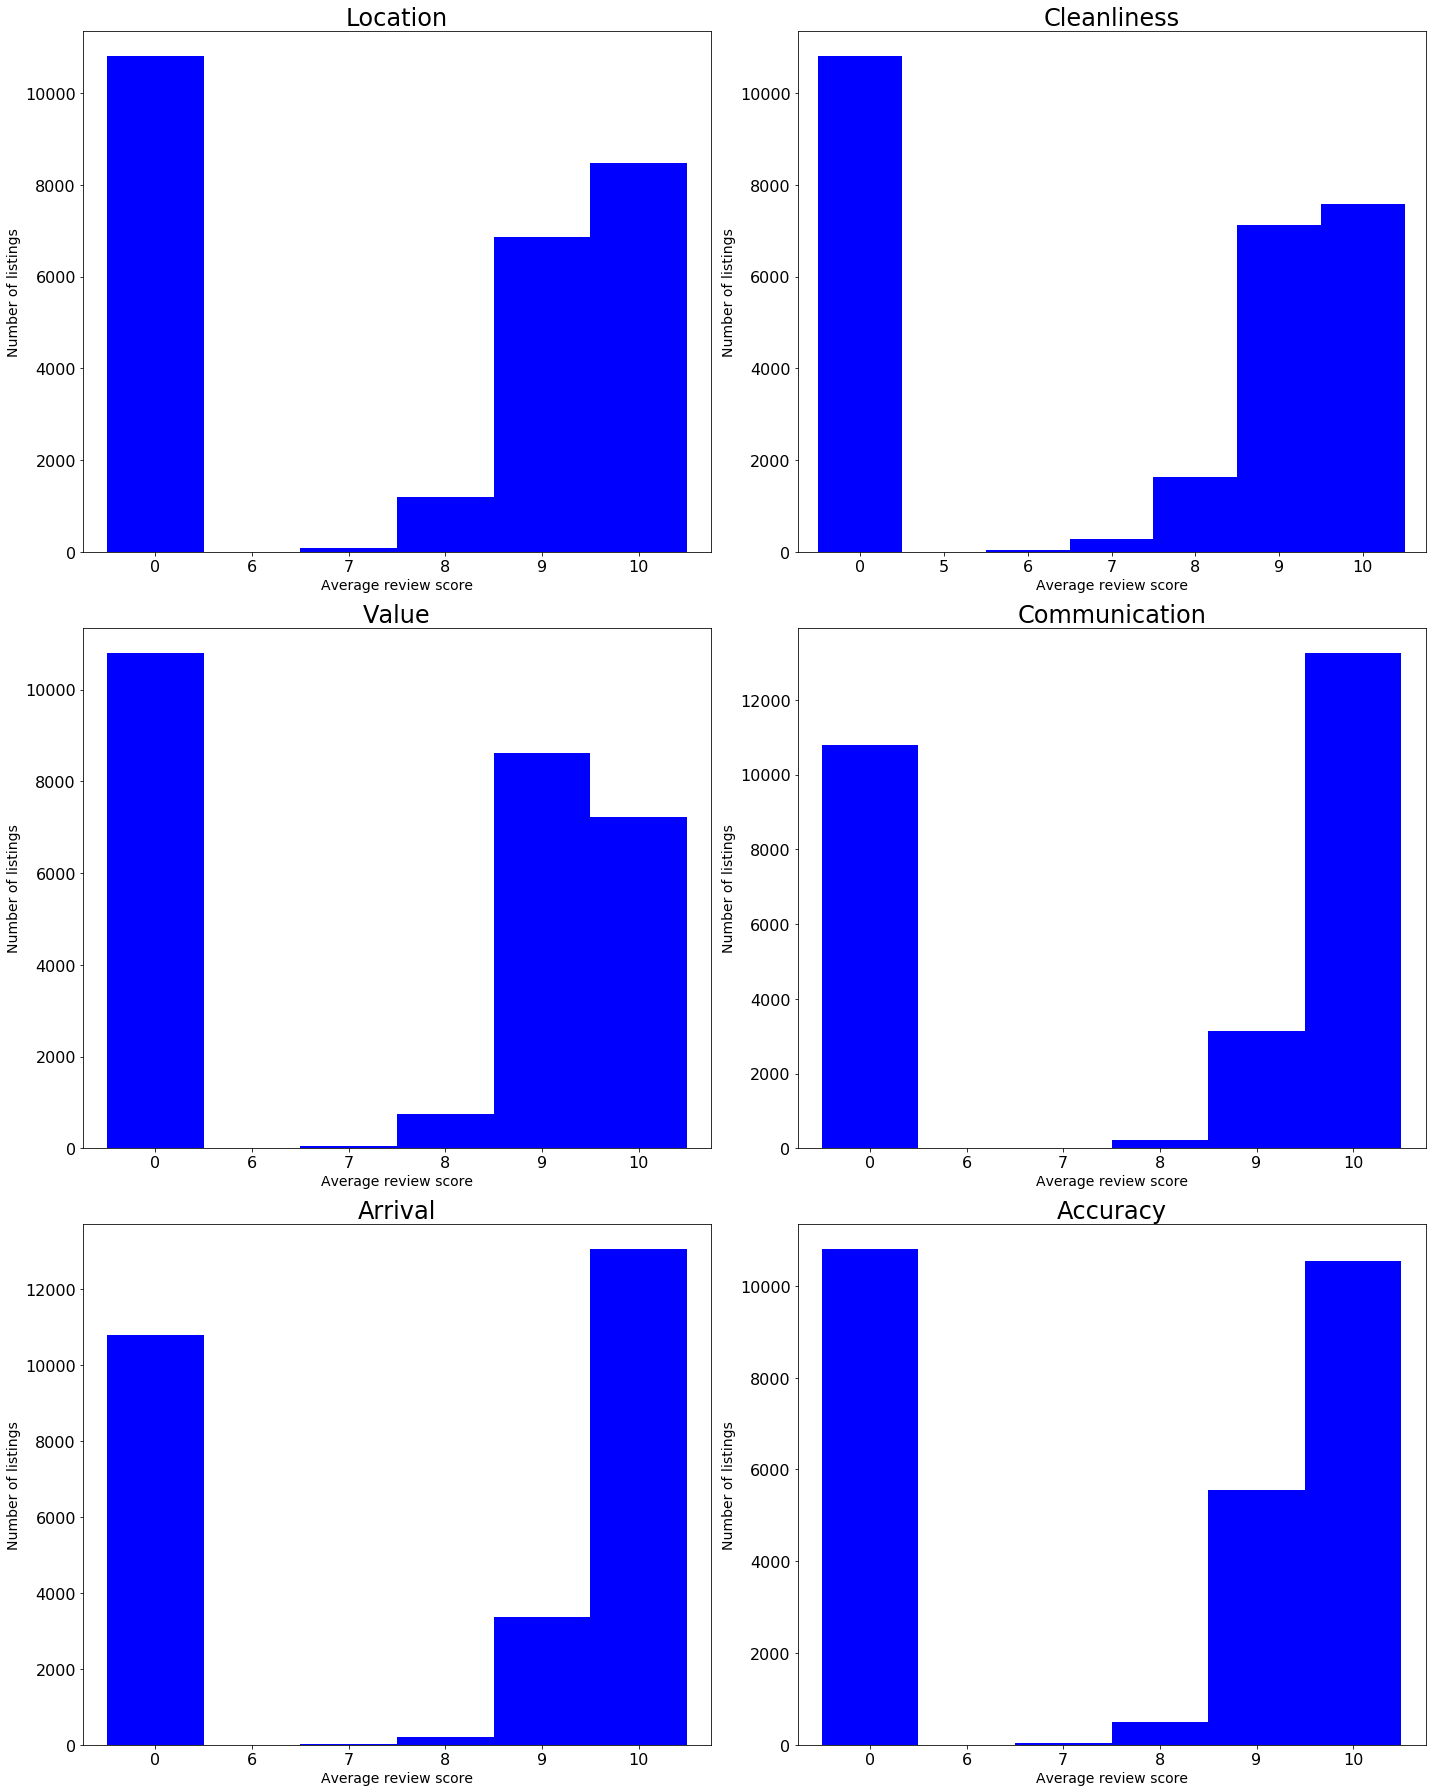

In [15]:
listings10 = NY[(NY['Number_of_reviews']>=10)]

fig = plt.figure(figsize=(20,25))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['Review_Scores_Location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['Review_Scores_Cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['Review_Scores_Value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['Review_Scores_Communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['Review_Scores_Checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['Review_Scores_Accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()
hide_toggle()

In [ ]:
уберем нулевые значения

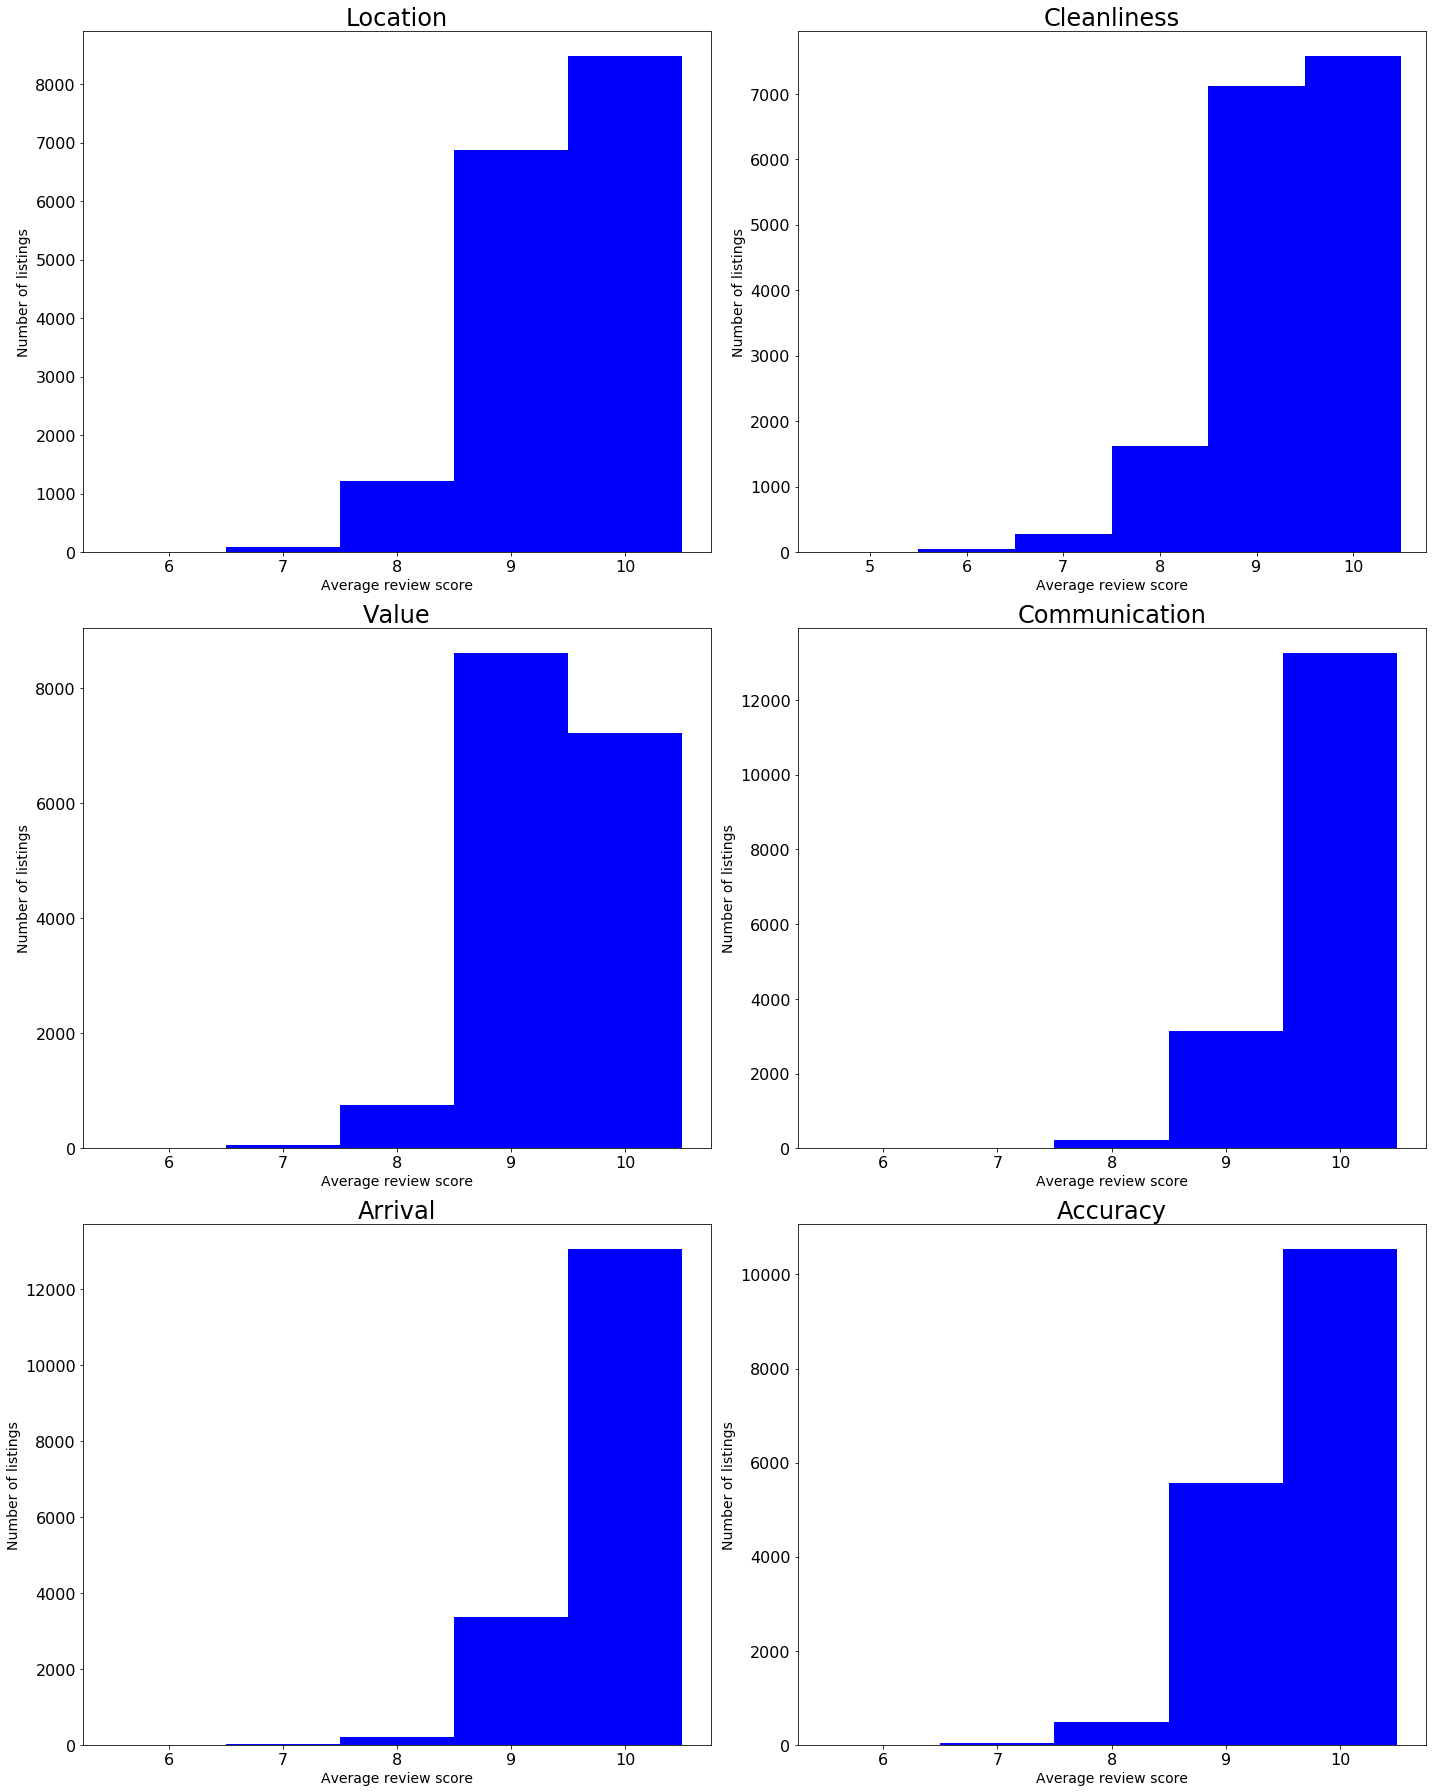

In [18]:
listings10 = NY[(NY['Number_of_reviews']>=10)&(NY['Review_Scores_Location']>0)&(NY['Review_Scores_Cleanliness']>0)
              &(NY['Review_Scores_Value']>0) &(NY['Review_Scores_Communication']>0)&(NY['Review_Scores_Checkin']>0)
               &(NY['Review_Scores_Accuracy']>0)]

fig = plt.figure(figsize=(20,25))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['Review_Scores_Location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['Review_Scores_Cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['Review_Scores_Value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['Review_Scores_Communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['Review_Scores_Checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['Review_Scores_Accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()
hide_toggle()

Посмотрим,как количество кроватей влияют на показатель "Чистота" в зависимости от типа комнаты?

Опять отбросим нулевые значения и возьмем людей, у которых количество отзывов больше 10.

Как видно, особой зависимости нет. То есть оценку 10 можно получить при любом количестве кроватей.

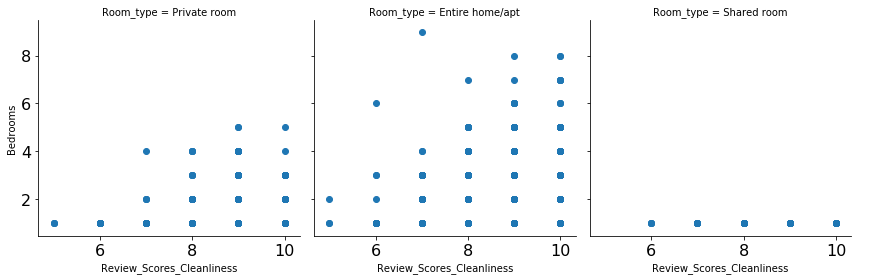

In [20]:
sns.FacetGrid(listings10, col="Room_type", height = 4).map(plt.scatter, "Review_Scores_Cleanliness", "Bedrooms").add_legend() 
hide_toggle()

 Посмотрим, как влияет расположение и район на положительность отзывов
 
В Манхэтане и Бруклине больше всего людей сдают помещения, то есть это популярные районы

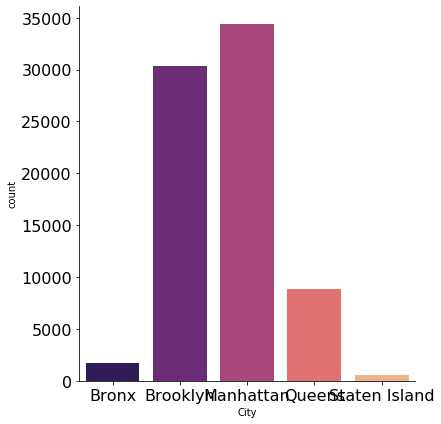

In [19]:
sns.catplot(x="City", kind="count",palette="magma", data=NY, height = 6)
# в манхэтане и бруклине больше всего людей сдают - популярные районы
hide_toggle()

несмотря на то, что манхэтн и бруклин самые популярные города, рейтинг там не самый высокий
Рейтинги в общем (Score) во всех регионах примерно одинаковое. Но в Ststen Island нет оценки 99-100, хотя средний рейтинг (медиана) выше, чем в Манхэтане, а этот район популярный.

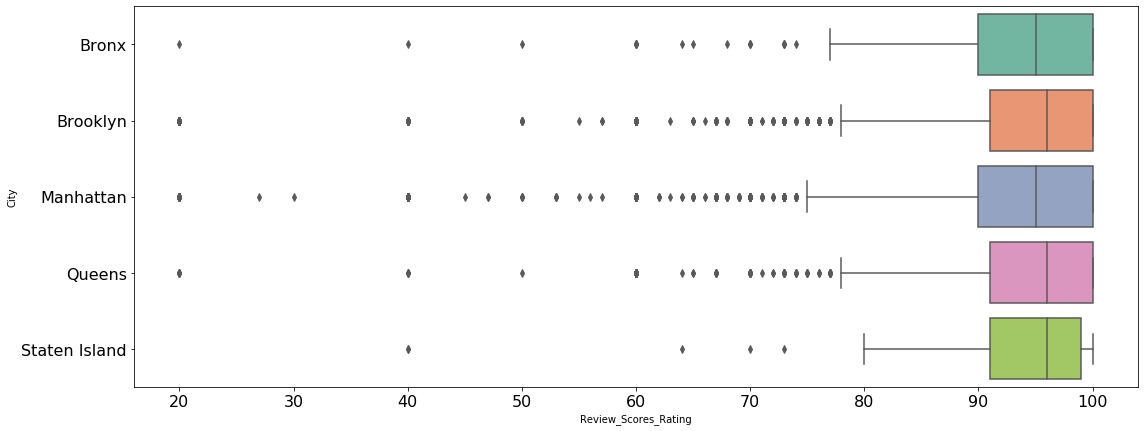

In [22]:
NY1 = NY[(NY.Review_Scores_Rating <5000)&(NY.Review_Scores_Rating >0)]
plt.figure(figsize=(18,7))
sns.boxplot(y="City", x="Review_Scores_Rating", data = NY1 , orient="h", palette = 'Set2')
hide_toggle()

Просмотрим результаты оценки местоположения и оценки местоположения в зависимости от цены
В этом разделе я группирую оценки по местоположению сначала по соседям, но это оказалось не информативно, а потом анализировала по районам (только списки, содержащие не менее 10 отзывов). Хотя я ожидаю, что расстояние до центра города
является важным фактором, эти оценки также должны принимать во внимание другие вещи. Другие факторы могут включать в себя:


Шум. Если список расположен в центре, но окружен шумными полосами, это должно стоить очков в оценке местоположения.

Если хост расположен за пределами центра города, но хорошо связан общественным транспортом, 
он должен получить за это бонусные баллы.

Услуги рядом с списком. Есть ли поблизости супермаркеты, бары и рестораны и другая инфраструктура.
Некоторые люди могут искать бесплатную парковку, если они приезжают на машине.

Ниже мы видим, что центральные районы (Манхэтн и Бруклин), которые, как правило, также были самыми дорогими, как правило, также получают более высокие оценки по обзору местоположения. (То есть шум не так сильно влияет, как хорошая инфраструктура)

Staten Island имеет следующее за центральными районами место. Значит, скорее всего та хорошо налажен общ. транспорт и добраться до центра не сложно.

Если бы я рассчитывала расстояние до центра города для каждого хоста, я ожидаю увидеть довольно сильную корреляцию между
этим расстоянием и ценой, и оценкой местоположения.

Глядя на средний балл обзора, я вижу, что средний показатель выше 8/10 для всех районов!




 Таким образом, не требуется много времени, чтобы добраться до центра города из любого места, что может объяснить
высокие средние значения в определенной степени. То есть выгоднее подумать о более доступном жилье 
за пределами центра города, в безопасном районе и в любом случае с хорошим транспортным сообщением с центром города.






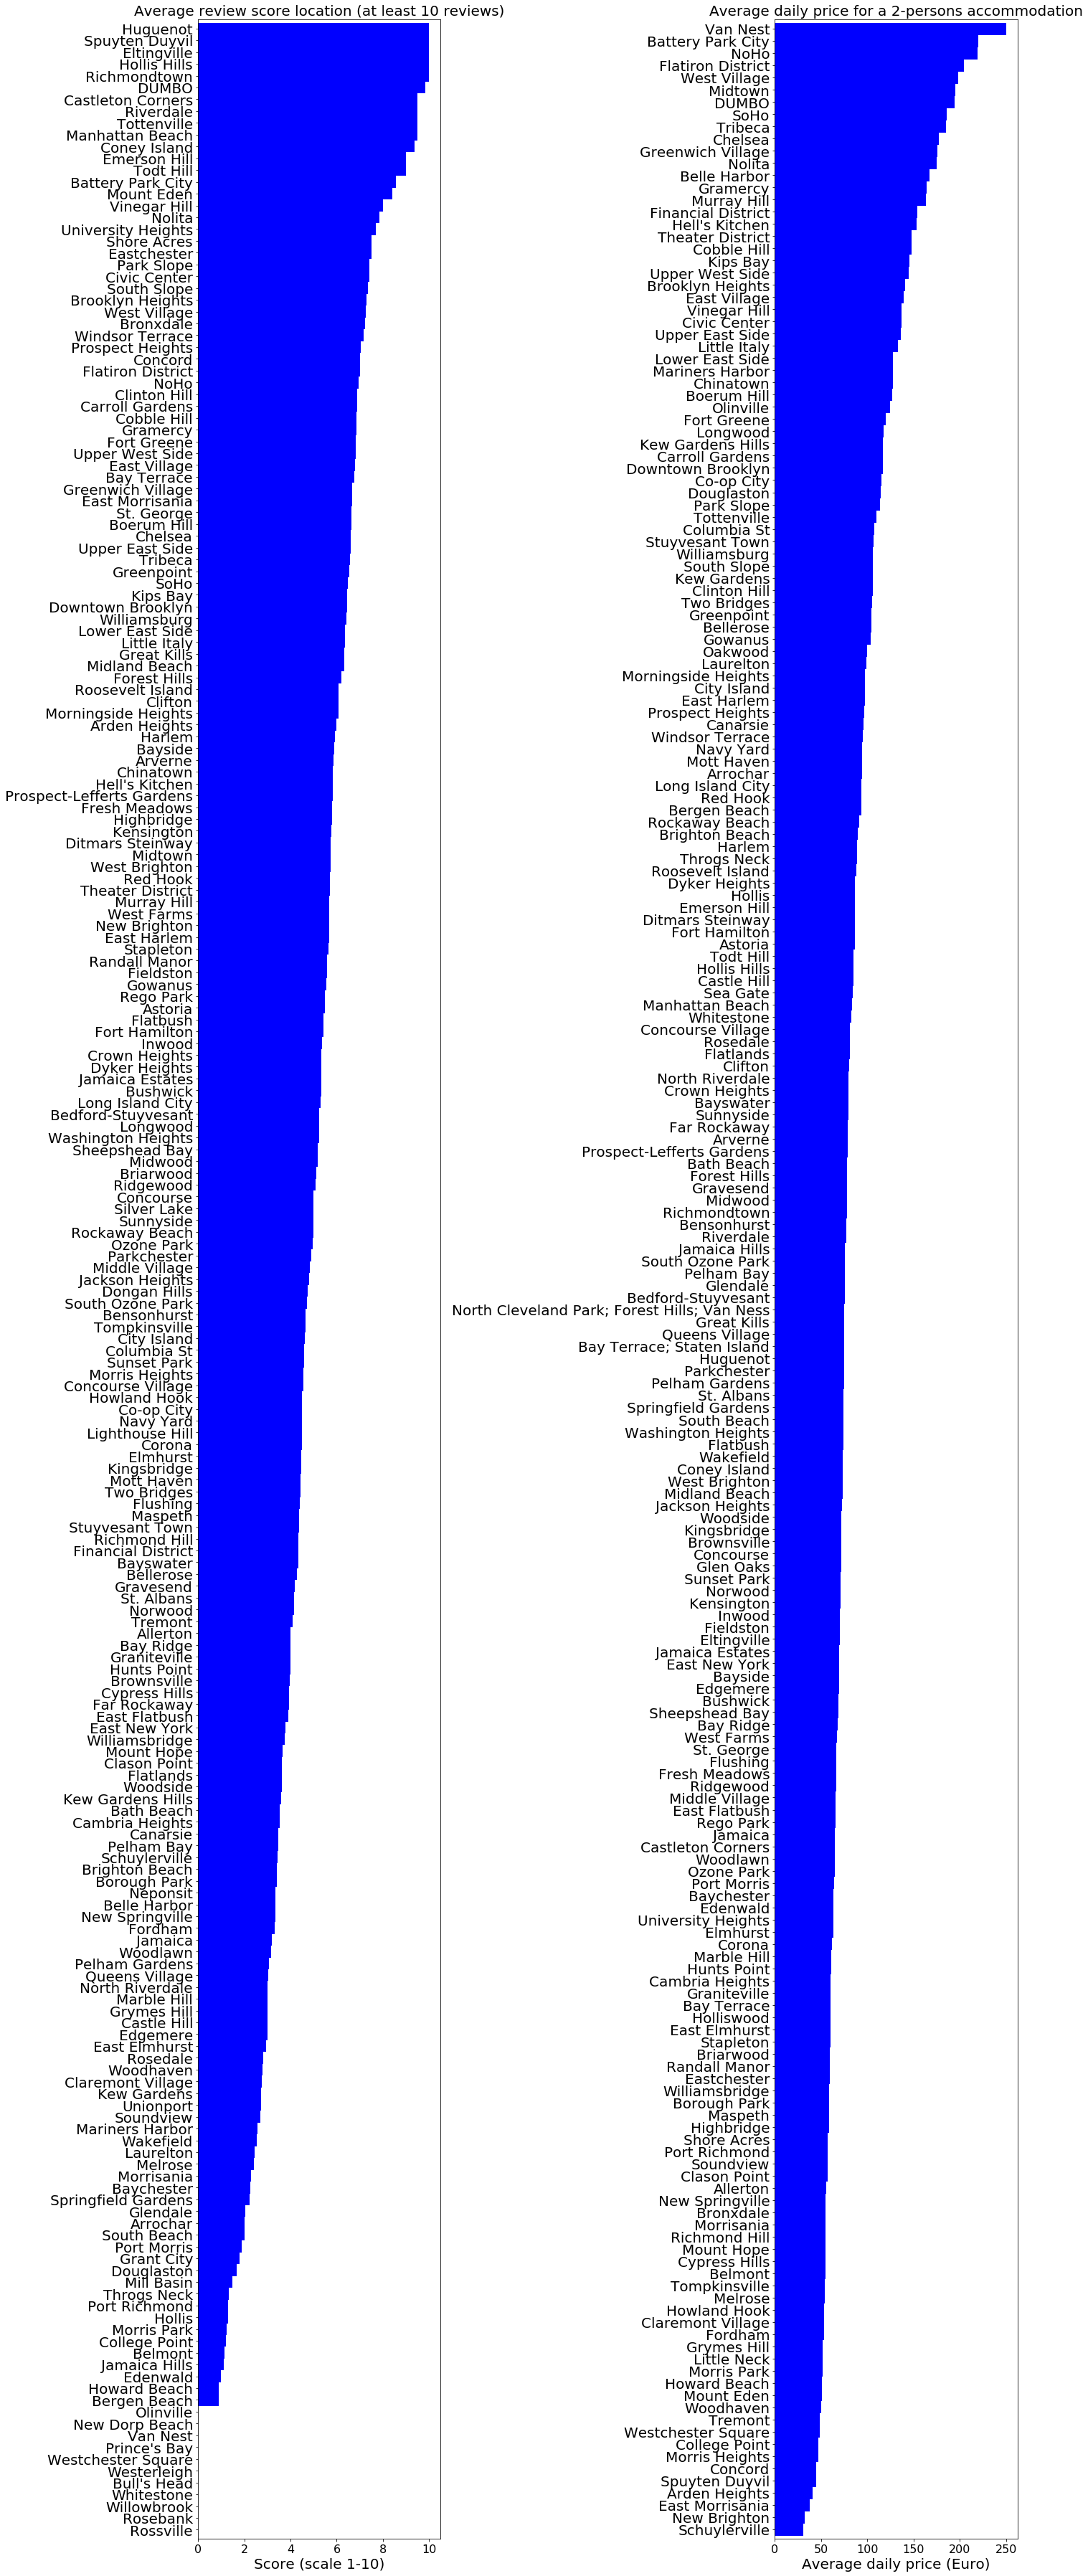

In [26]:
fig = plt.figure(figsize=(20,50))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = NY[NY['Number_of_reviews']>=10]
feq1 = feq.groupby('Neighbourhood_cleansed')['Review_Scores_Location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = NY[NY['Accommodates']==2]
feq2 = feq.groupby('Neighbourhood_cleansed')['Price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()
hide_toggle()


это не очень информативно
посмотрим по районам

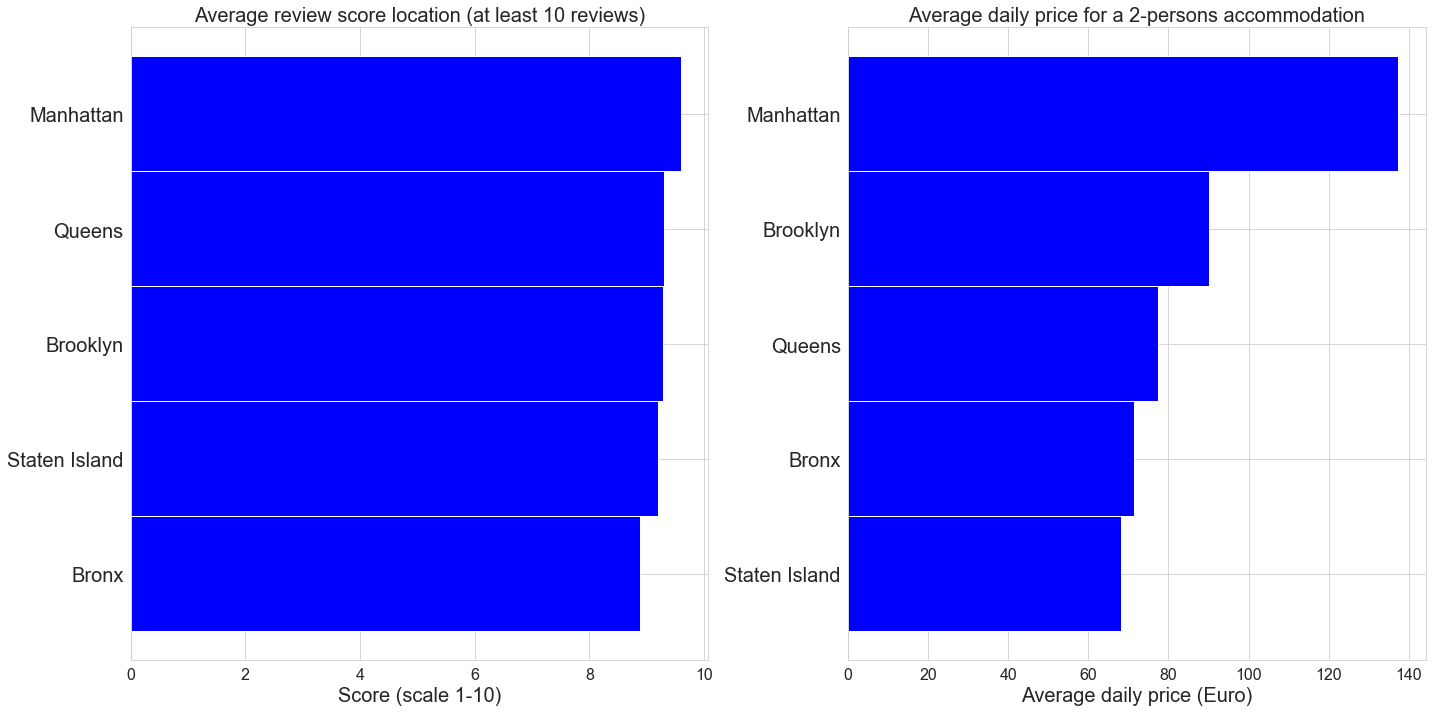

In [46]:
NY[(NY['Number_of_reviews']>=10)&(NY['Review_Scores_Location']>0)&(NY['Review_Scores_Cleanliness']>0)
              &(NY['Review_Scores_Value']>0) &(NY['Review_Scores_Communication']>0)&(NY['Review_Scores_Checkin']>0)
               &(NY['Review_Scores_Accuracy']>0)]




fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = NY[(NY['Number_of_reviews']>=10)&(NY['Review_Scores_Location']>0)]
feq1 = feq.groupby('City')['Review_Scores_Location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = NY[NY['Accommodates']==2]
feq2 = feq.groupby('City')['Price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()
hide_toggle()

убрали нулевые

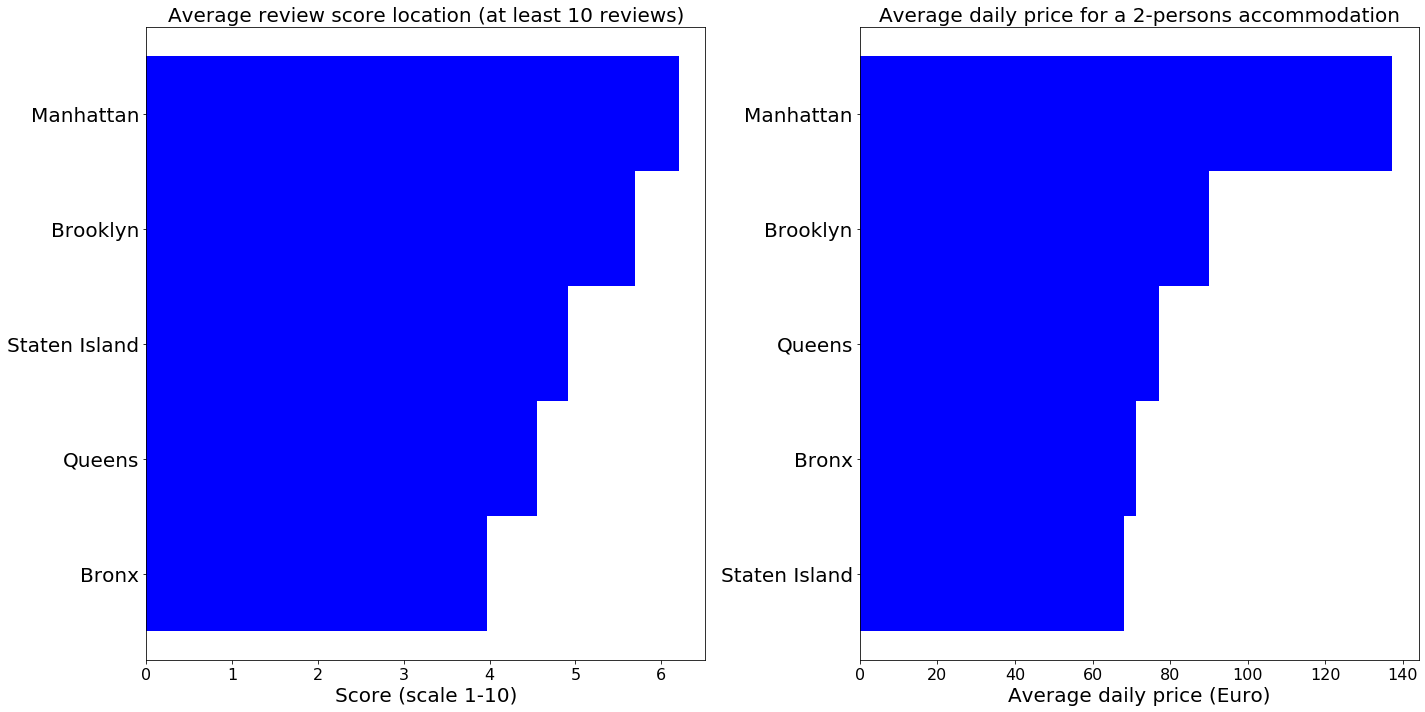

In [25]:



fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = NY[NY['Number_of_reviews']>=10]
feq1 = feq.groupby('City')['Review_Scores_Location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = NY[NY['Accommodates']==2]
feq2 = feq.groupby('City')['Price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()
hide_toggle()

Коэффициент проверки 50% используется для преобразования отзывов в приблизительные заказы.
Утверждается, что другие административные органы используют коэффициент проверки 72% 
(однако это может быть связано с ненадежным источником: генеральным директором Airbnb и)
- или одним из 30,5% 
Внутри Airbnb выбрали 50%, поскольку он находится почти точно между 72% и 30,5%. В основном это означает,
что только 50% всех посетителей пишут отзыв.

С учетом вышесказанного, количество отзывов в месяц, деленное на рейтинг отзывов, равно оценке фактических посетителей.
Средняя продолжительность пребывания в каждом городе обычно публикуется Airbnb. Это число, умноженное 
на расчетное количество бронирований для каждого списка за определенный период времени, дает показатель занятости.

И, наконец, доход можно рассчитать, умножив коэффициент занятости на цену и период интереса - здесь, 12 месяцев:

Ежемесячный коэффициент занятости = средняя продолжительность пребывания * (количество отзывов в месяц / показатель отзывов)
 гости, которые забронировали проживание в Нью Йорке провели здесь в среднем 4 ночи.

Годовой доход = Ежемесячная занятость Цена 12 месяцев

Monthly Occupancy Rate = Average Length of Stay * (No. of reviews per Month / Review Rate)
Yearly Income = Monthly Occupancy Rate Price 12 Months




С очень скромной оценкой 0,5, мы предполагаем, что только каждый второй гость оставил отзыв. 


In [39]:
avg_length_of_stay = 4.5
review_rate_modest = 0.5

# calculate the occupancy and round the result
NY['modest_occupancy'] = round(avg_length_of_stay * (NY['Reviews_per_month']/review_rate_modest), 2)

# Ежемесячный коэффициент занятости не может быть больше 100% - есть ошибки? - 
len(NY[NY['modest_occupancy'] > 100])

0

In [37]:
 #let's drop occupancy rates > 100
NY.drop(NY[(NY['modest_occupancy'] > 100)].index, axis=0, inplace=True)
# check the distribution
NY['modest_occupancy'].describe()


count    75524.000000
mean         9.929909
std         13.224797
min          0.000000
25%          0.450000
50%          4.050000
75%         14.760000
max         79.740000
Name: modest_occupancy, dtype: float64

Оптимистичная оценка

Теперь давайте попробуем получить более оптимистичную оценку занятости, используя коэффициент 
обзора 0,4, который предполагает, что только 40% всех гостей оставили отзыв. 
Таким образом, количество отзывов указывает на более высокую занятость, чем в скромной оценке, которую мы имели ранее:

In [30]:
review_rate_optimistic = 0.4

# calculate the occupancy and round the result
NY['optimistic_occupancy'] = round(avg_length_of_stay * (NY['Reviews_per_month']/review_rate_optimistic), 2)

# Ежемесячный коэффициент занятости не может быть больше 100% - есть ошибки? - нет
len(NY[NY['optimistic_occupancy'] > 100])

145

In [31]:
# let's drop the occupancy rates > 100
NY.drop(NY[(NY['optimistic_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
NY['optimistic_occupancy'].describe()

count    75524.000000
mean        12.412109
std         16.530929
min          0.000000
25%          0.560000
50%          5.060000
75%         18.450000
max         99.680000
Name: optimistic_occupancy, dtype: float64

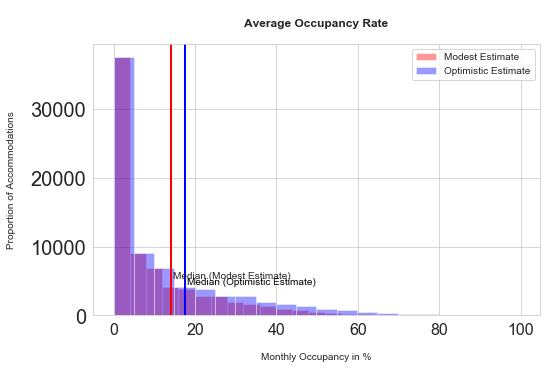

In [40]:
#Сравним оценки


sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(NY['modest_occupancy'], kde=False, bins=20, color='red')
sns.distplot(NY['optimistic_occupancy'], kde=False, bins=20, color='blue')

plt.title('\nAverage Occupancy Rate\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=14, ymin=0, ymax=1, linewidth=2, linestyle='-', color='red')
plt.text(14.5, 5350, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=17.5, ymin=0, ymax=1, linewidth=2, linestyle='-', color='blue')
plt.text(18, 4500, 'Median (Optimistic Estimate)', color='black');
hide_toggle()

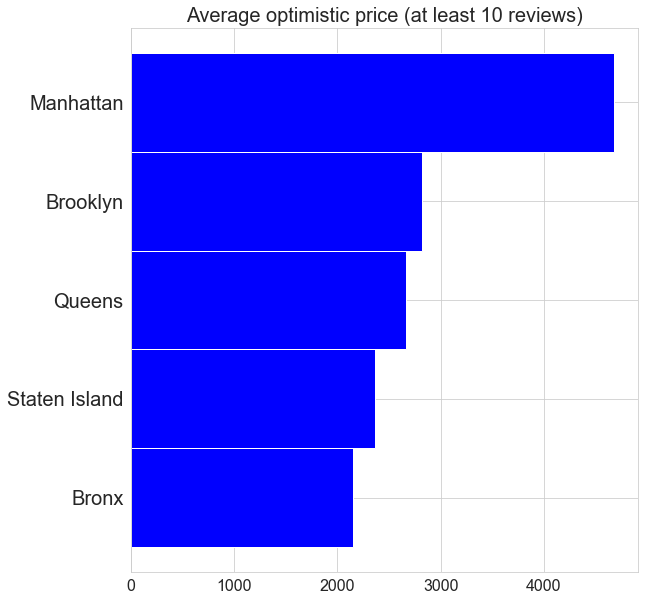

In [41]:
NY['optimistic_occupancy'] = round(avg_length_of_stay * (NY['Reviews_per_month']/review_rate_optimistic), 2)
NY['optimistic_price']  = NY['optimistic_occupancy']*NY['Price']

fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = NY[(NY['Number_of_reviews']>=10)]
feq1 = feq.groupby('City')['optimistic_price'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average optimistic price (at least 10 reviews)", fontsize=20)
#plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")
hide_toggle()

Если бы я бронировала жилье, я бы не обязательно искала суперхоста. 
На самом деле, я боялась бы, что я заплачу слишком много, поскольку суперхост,
вероятно, увеличит  цены. Тем не менее, я также не хотела бы, чтобы хост,  плохо реагировал бы или отменял много.

Как мы видим, более 5000 из 20 000 списков имеют не менее 10 отзывов и 
отвечают как минимум на 90% новых сообщений. Я бы посчитала эти хосты «проверенными» 
хорошими респондентами (что не означает, что список с менее чем 10 отзывами не может иметь
                        хороших хостов).

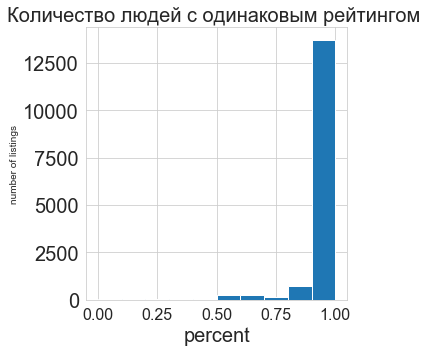

In [43]:


fig = plt.figure(figsize=(10,5))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['Host_Response_Rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Количество людей с одинаковым рейтингом ", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)



plt.tight_layout()
plt.show()
hide_toggle()

In [ ]:
Как видно, есть большое количество людей, которые не имеют статус Суперхозяина, но при этом имеют хорошие отзывы

In [45]:
listingsSH = NY[(NY['Number_of_reviews']>=10)&(NY['Review_Scores_Location']>0)&(NY['Review_Scores_Cleanliness']>0)
              &(NY['Review_Scores_Value']>0) &(NY['Review_Scores_Communication']>0)&(NY['Review_Scores_Checkin']>0)
               &(NY['Review_Scores_Accuracy']>0)&(NY.Host_Response_Rate >=0.86)]

yS = NY[NY.Host_Is_Superhost == True].groupby('Host_Response_Rate')['Host_Response_Rate'].count()
yH = NY[NY.Host_Is_Superhost == False].groupby('Host_Response_Rate')['Host_Is_Superhost'].count()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=listingsSH.Host_Response_Rate,
    y=yH,
    name='Host',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=listingsSH.Host_Response_Rate,
    y=yS,
    name='Superhost',
    marker_color='lightgreen'
))


fig.update_layout(barmode='group')
fig.show()
hide_toggle()